# Testing if passing z* iteratively would lead to better depth estimate 

Making changes in the forward function

## Imports

In [73]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import plotly 
#plotly.tools.set_credentials_file(username='mishra40', api_key='nuOxcWWzZSBv7dFtO4F3')
import chart_studio.plotly as py
import plotly.graph_objs as go
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
__pyTorch VERSION: 1.1.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
__CUDNN VERSION: 7501
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


## Utils

In [74]:

def num_edges(n):
    return int(n*(n-1)/2)

def restructure_conn_mat(hverts, vverts, conn):
    conn_mat=conn
    new_conn_mat = torch.Tensor()
    nverts = hverts+vverts
    tot = int((vverts*(vverts-1))/2)
    nv_seq = np.arange(nverts)[::-1]
    vv_seq = np.arange(vverts)[::-1]
    # convert vverts conn_mat to nverts conn_mat
    for i,v in enumerate(vv_seq):
            if (v==0):
                break
            pad = min(nverts-vverts, nverts-i-1)
            n1 = max(vverts-i-1,0)
            n2 = tot - n1
            #print("i,pad,n1,n2,tot,conn_mat -- ",i,pad,n1,n2,tot,conn_mat)
            if (tot > 1): 
                c1,c2 = torch.Tensor.split(conn_mat,[n1,n2],dim=2)
            else:
                c1 = conn_mat #torch.Tensor.clone(conn_mat)
                c2 = torch.Tensor(conn_mat) #torch.Tensor.zero_(conn_mat)
            if (tot==0):
                pad = pad-1
            m = nn.ConstantPad2d((0,pad,0,0),1)
            c1 = m(c1)
            new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
            #print("adding hidden verts in new_conn_mat -- ",new_conn_mat)
            conn_mat = c2
            tot = c2.size()[-1]
            #print("new conn mat shape: ", new_conn_mat.shape)
    # number of elements to skip from vverts        
    n = vv_seq[0]        
    # create rest of vverts conn_mat
    for i,v in enumerate(nv_seq[n:]):
        if (v==0):
            break  
        c1 = torch.ones(1,3,v)
        new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
        
    #new_conn_mat = expand_conn_mat(maxverts,nverts,new_conn_mat)    
    return new_conn_mat

def expand_conn_mat(nverts, vverts, conn):
    conn_mat=conn
    new_conn_mat = torch.Tensor()
    tot = int((vverts*(vverts-1))/2)
    nv_seq = np.arange(nverts)[::-1]
    vv_seq = np.arange(vverts)[::-1]
    # convert vverts conn_mat to nverts conn_mat
    for i,v in enumerate(vv_seq):
            if (v==0):
                break
            pad = min(nverts-vverts, nverts-i-1)
            n1 = max(vverts-i-1,0)
            n2 = tot - n1
            #print("i,pad,n1,n2,tot,conn_mat -- ",i,pad,n1,n2,tot,conn_mat)
            if (tot > 1): 
                c1,c2 = torch.Tensor.split(conn_mat,[n1,n2],dim=2)
            else:
                c1 = conn_mat #torch.Tensor.clone(conn_mat)
                c2 = torch.Tensor(conn_mat) #torch.Tensor.zero_(conn_mat)
            if (tot==0):
                pad = pad-1
            m = nn.ZeroPad2d((0,pad,0,0))
            c1 = m(c1)
            new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
            #print("new_conn_mat -- ",new_conn_mat)
            conn_mat = c2
            tot = c2.size()[-1]
    # number of elements to skip from vverts        
    n = vv_seq[0]        
    # create rest of vverts conn_mat
    for i,v in enumerate(nv_seq[n:]):
        if (v==0):
            break  
        c1 = torch.zeros(1,3,v)
        new_conn_mat = torch.cat((new_conn_mat,c1), dim=2)
    return new_conn_mat



## Network - layers for learning z' from z and mapping SDA from Gram Mat

Still using network within network

In [128]:
# new version
import torch.nn.functional as F 
from functools import reduce

class DepthEstNet(nn.Module):    
    def __init__(self, vertices, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(DepthEstNet, self).__init__()
        self.vertices = vertices
        input_dim = vertices * 3
        self.edges = int(num_edges(vertices))
        edge_dim = self.edges * 3
        edges = self.edges
        self.conv_edge_vec = nn.ModuleList()
        self.conv_edge_num = vertices-1
        
        self.fc0 = nn.Linear(vertices, vertices)
        #self.conv_edge_vec.append(fc0)
        #torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            m.requires_grad = False
            self.conv_edge_vec.append(m)
        
        for i in range(self.conv_edge_num):
            params = self.conv_edge_vec[i].parameters()
            for p in params:
                p.requires_grad=False        
                
        
#         self.deconv_edge_vec = nn.ModuleList()
#         self.deconv_edge_num = vertices-1
#         for i in range(1,vertices):
#             m = nn.Conv1d(3, 3, 2, stride=1, dilation=vertices-i)
#             m.requires_grad = True
#             self.deconv_edge_vec.append(m)        
        
        
        self.reverse_learn_params = nn.ModuleList()
        fc1 = nn.Linear(vertices, edges)
        self.reverse_learn_params.append(fc1)
        fc2 = nn.Linear(edges, edges*10)
        self.reverse_learn_params.append(fc2)
        fc3 = nn.Linear(edges*10, vertices)
        self.reverse_learn_params.append(fc3)
        
        
        fc4 = nn.Linear(edges, edges*10)
        self.reverse_learn_params.append(fc4)
        fc5 = nn.Linear(edges*10, 1)
        self.reverse_learn_params.append(fc5)
        
        fc6 = nn.Linear(edges, edges*10)
        self.reverse_learn_params.append(fc6)
        fc7 = nn.Linear(edges*10, vertices*10)
        self.reverse_learn_params.append(fc7)
        fc8 = nn.Linear(vertices*10, vertices)
        self.reverse_learn_params.append(fc8)
        
        
#         self.layernorm = nn.LayerNorm(edges)
#         self.nonlinearity = nonlinearity
#         self.cos = nn.CosineSimilarity(dim=0, eps=1e-6)

    def show_grad(self):
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i]
            print("#", i, "conv net grads: ",y.weight.grad,y.bias.grad)
        for y in (self.reverse_learn_params):
            print("other grads: ",y.weight.grad,y.bias.grad)
        
        
    def forward(self, vverts, conn_mat, debug=False, extract_x=False, extract_y=False, extract_z=False):
        
        n,d,vv = vverts.size()
        #print(n,d,v)
    
        #padding for missing verts
        nverts = self.vertices
        pad = nverts - vv
        m = nn.ZeroPad2d((0, pad, 0, 0)) #padding(left,right,top,bottom)
        xyz = m(vverts)
        
        if (debug == True): print("initial xyz", xyz)
            
        x_vec = xyz[:,0,:] 
        y_vec = xyz[:,1,:]
        z_vec = xyz[:,2,:]

        if (debug == True): print("initial z", z_vec)
        
        temp = (self.reverse_learn_params[0](z_vec))
        temp = (self.reverse_learn_params[1](temp))
        z_vertexs_recovered = self.reverse_learn_params[2](temp)
        
        new_xyz = []
        new_xyz.append(x_vec.squeeze(0))
        new_xyz.append(y_vec.squeeze(0))
        new_xyz.append(z_vertexs_recovered.squeeze(0))
        new_xyz = torch.stack(new_xyz).unsqueeze(0)
        
        if (debug == True): print("new xyz", new_xyz)
        
        n,d,num_v_edge = conn_mat.size()
        #conn_mat = expand_conn_mat(nverts,vv,conn_mat)


        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](new_xyz)
            #y = self.nonlinearity(y)
            #print("#", i, "conv net output: ",y)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
    
        if (debug == True): print("Conv output: ", output)            
        c_x_vec = output[:,0,:] 
        c_y_vec = output[:,1,:]
        c_z_vec = output[:,2,:]
        
        norm_mat = F.normalize(output, p=2, dim=1)
        
        if (debug == True): print("Normalized output",norm_mat)
        
        gram_mat = [torch.mm(mat.transpose(1,0),mat) for mat in norm_mat[:]]
        gram_mat = torch.stack(gram_mat)
        
        filter_mat = [torch.mm(mat.transpose(1,0),mat) for mat in conn_mat[:]]
        filter_mat = torch.stack(filter_mat)

                
        N = self.vertices
        mat_row = []
        for r in range(N-1,0,-1):
            mats = []
            for n in range(r,0,-1):
                #print("n = ",n)
                f = np.ones((n,n), dtype=int)
                for i in range(1,n):
                    f[-i-2::-1,-i] = 0 
                f = f.T&f
                mat = np.copy(f)
                pad = r-n
                for j in range(pad,0,-1):
                    if (j>n):
                        p = np.zeros((1,n), dtype=int)
                    else:
                        p = f[:,-j]
                    mat = np.vstack((mat,p))   
                #print("mat shape: ", mat.shape)
                mats.append(mat)

            mats=np.hstack(mats)

            #print(mats)

            pad = int(N*(N-1)/2) - mats.shape[1] 
            m = nn.ZeroPad2d((pad, 0, 0, 0)) #padding(left,right,top,bottom)

            mats = torch.from_numpy(np.asarray(mats,dtype=np.float32))
            mat_row.append(m(mats))

        mat_row = torch.cat(mat_row)    
    
#         if (debug == True): print("gram * conn", gram_mat*filter_mat)
        
#         gram_mat = gram_mat*filter_mat*mat_row
        
#         if (debug == True): print("gram * conn * mat_row", gram_mat)

        gram_mat = torch.clamp(gram_mat, min=-0.99999, max=0.99999)
        
        if (debug == True): print("gram mat clamped: ", gram_mat)
            
        ang = torch.acos(gram_mat)*filter_mat*mat_row
        
        if (debug == True): print("filtered ang",np.rad2deg(ang.detach().numpy()))
            
        sda = torch.std(ang)
        
        if (debug == True): print("filtered sda", sda)            

        temp = (self.reverse_learn_params[5](c_x_vec))
        temp = (self.reverse_learn_params[6](temp))
        vertexs_recovered = (self.reverse_learn_params[7](temp))
        optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 1e-1 , momentum=0.8)
        criterion = nn.MSELoss()
        optimizer.zero_grad()
        if (debug == True): print(" vertexs_recovered:", vertexs_recovered)
        #print(" x[:,0,:]:", x[:,0,:])
        loss = criterion(vertexs_recovered, x_vec)
        if (debug == True): print("network reverse loss", loss)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        

#         optimizer = torch.optim.SGD(self.reverse_learn_params.parameters(), lr = 1e-1 , momentum=0.8)
#         criterion = nn.MSELoss()
#         optimizer.zero_grad()
#         loss = torch.std(gram_mat) #criterion(gram_mat, torch.Tensor.new_zeros(gram_mat, gram_mat.size()))
#         loss.backward(retain_graph=True)
#         optimizer.step()
                  

        
#         n,d,e = output.size()            
#         output = F.normalize(output, p=2, dim=1)
#         output = [torch.mm(mat.transpose(1,0),mat) for mat in output[:]]
#         return torch.stack(output)

#         temp = (self.reverse_learn_params[3](gram_mat))
#         sda = (self.reverse_learn_params[4](temp))
        
        
        
        if (debug == True): print("sda", sda)
            
            
        if (extract_z):
            temp = (self.reverse_learn_params[5](c_z_vec))
            temp = (self.reverse_learn_params[6](temp))
            z_vertexs_recovered = (self.reverse_learn_params[7](temp))
            
    
            temp = (self.reverse_learn_params[5](c_y_vec))
            temp = (self.reverse_learn_params[6](temp))
            y_vertexs_recovered = (self.reverse_learn_params[7](temp))
            
    
            temp = (self.reverse_learn_params[5](c_x_vec))
            temp = (self.reverse_learn_params[6](temp))
            x_vertexs_recovered = (self.reverse_learn_params[7](temp))
            
            return (x_vertexs_recovered, y_vertexs_recovered, z_vertexs_recovered, sda)  
        
        return sda,ang

## Create the model with Given N Verts

In [195]:
nverts = 20
model = DepthEstNet(nverts, nonlinearity=fn.sigmoid, additional_hidden_wide=1)

## Create Training Set
Objects are Cubes 

In [130]:
train_xy_obj = [] #torch.Tensor()
train_xyz_obj = []
train_xy_conn = []
train_xy_deg = [] 
train_xy_ang = []
train_xy_sda = []

objs = []

with open('training/vverts/cube/data.pickle.5.p.1000.objs', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    if(i%5 > 0):
        continue
    obj = np.asarray(data[i])
    conn = np.asarray(data[i+1]) 
    deg = np.asarray(data[i+2]) 
    angs = np.asarray(data[i+3]) 
    sda = np.asarray(data[i+4]) 
    print("obj: ", obj)
    print("obj shape: ", obj.shape)
    objs.append(np.copy(obj))
    
    print("deg: ", deg)
    deg = torch.from_numpy(np.asarray(deg,dtype=np.float32))
    deg = deg.unsqueeze(0)
    train_xy_deg.append(deg)
    
    print("ang: ", angs)
    angs = torch.from_numpy(np.asarray(angs,dtype=np.float32))
    angs = angs.unsqueeze(0)
    train_xy_ang.append(angs)
    
    
    print("sda: ", sda)
    sda = torch.from_numpy(np.asarray(sda,dtype=np.float32))
    sda = sda.unsqueeze(0)
    train_xy_sda.append(sda)
    
    
    #train_xyz_obj.append(torch.from_numpy(np.asarray(obj,dtype=np.float32)).unsqueeze(0))  
    
    vv = obj.shape[1]
    print("vv: ",vv)
    #obj[2,0:vv]=0
    vverts = torch.from_numpy(np.asarray(obj,dtype=np.float32))
    vverts = vverts.unsqueeze(0)
    pad = nverts - vv
    m = nn.ZeroPad2d((0, pad, 0, 0)) #padding(left,right,top,bottom)
    x = m(vverts)
    train_xyz_obj.append(x)   
    
    
    
    conn = torch.from_numpy(np.asarray(conn,dtype=np.float32))
    conn = conn.unsqueeze(0)
    print("conn: ", conn)
    print("conn shape: ", conn.shape)
    conn_mat = restructure_conn_mat(8-vv,vv,conn)
#    print("hidden conn mat: ", conn_mat)
    print("restrcutured conn shape: ", conn_mat.shape)
    conn_mat = expand_conn_mat(nverts,8,conn_mat)
#     print("expanded conn mat: ", conn_mat)  
    print("conn shape: ", conn_mat.shape)
    train_xy_conn.append(conn_mat)


# train_xy_obj = torch.cat(train_xy_obj)
# print(train_xy_obj.shape)

train_xyz_obj = torch.cat(train_xyz_obj)
print(train_xyz_obj.shape)

train_xy_conn = torch.cat(train_xy_conn)
print(train_xy_conn.shape)

# train_xy_deg = torch.cat(train_xy_deg)
# print(train_xy_deg.shape)

# train_xy_ang = torch.cat(train_xy_ang)
# print(train_xy_ang.shape)

train_xy_sda = torch.cat(train_xy_sda)
print(train_xy_sda.shape)

obj:  [[ 0.90317619  0.89676136  0.8714155   0.95537996 -0.86861604 -0.87958241
  -0.9065578 ]
 [ 0.25440401 -0.26004627  0.26125491 -0.25453183 -0.27034754  0.27190542
  -0.25685006]
 [-0.24140398 -0.26386589  0.231879    0.25779167 -0.24973027  0.24608999
   0.24514465]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.73573095  0.73050535  0.709858

ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.84925437  0.8432225   0.81938982  0.89834148 -0.81675756 -0.82706922
  -0.8524341 ]
 [ 0.78430831 -0.80170751  0.80543333 -0.78470218 -0.83346552  0.83826828
  -0.79184926]
 [-0.14055315 -0.15363607  0.13501199  0.15009475 -0.14540581  0.14328632
   0.1427311 ]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1

conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
          0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
          0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
          0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 28])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.483502    0.48006791  0.46649939  0.5114485  -0.46500075 -0.47087142
  -0.48531228]
 [ 0.17079248 -0.17457531  0.17538704 -0.17087846 -0.18149106  0.18253694
  -0.17243461]
 [-0.8204717  -0.89680868  0.78809369  0.87616915 -0.84876537  0.836393
   0.8331852 ]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.598

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.25442544  0.25261837  0.24547844  0.2691313  -0.24468984 -0.24777907
  -0.25537807]
 [ 0.83522403 -0.85375154  0.8577193  -0.83564353 -0.88757122  0.89268583
  -0.84325451]
 [-0.30505416 -0.33344242  0.29302144  0.32576284 -0.31557971  0.31097957
   0.3097811 ]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 

sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.79079115  0.78517455  0.76298255  0.83649909 -0.76053149 -0.77013326
  -0.79375201]
 [ 0.83500671 -0.85352862  0.85749537 -0.83542615 -0.88733947  0.89245278
  -0.84303504]
 [-0.41159531 -0.44989604  0.39535806  0.43953654 -0.42579475  0.41958803
   0.41797316]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.15198681  0.15090731  0.1466421   0.16077168 -0.146171   -0.14801644
  -0.15255587]
 [ 0.0298783  -0.03053843  0.03068053 -0.02989339 -0.03174828  0.03193126
  -0.03016558]
 [-0.35753137 -0.39079589  0.34342191  0.38180226 -0.36986038  0.36446899
   0.36307144]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.95453042  0.94775087  0.92096382  1.00970256 -0.91800523 -0.92959511
  -0.95810431]
 [ 0.72633404 -0.74244535  0.74589592 -0.72669888 -0.77185589  0.77630371
  -0.73331755]
 [-0.35881138 -0.39220032  0.34465641  0.38316935 -0.37118983  0.36577907
   0.36437133]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.51003659  0.506414    0.49210083  0.53951681 -0.49051994 -0.49671283
  -0.5119462 ]
 [ 0.30475074 -0.31150761  0.31295556 -0.30490389 -0.32384753  0.32571372
  -0.30768085]
 [-0.54055882 -0.59085417  0.51922834  0.57725459 -0.55920136  0.55104995
   0.548935  ]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 

vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.04895541  0.0486077   0.04723386  0.05178504 -0.04708212 -0.04767654
  -0.0491387 ]
 [ 0.40248379 -0.41140682  0.41331914 -0.40268609 -0.42770413  0.43016881
  -0.40635356]
 [-0.8209725  -0.89735782  0.78857636  0.87670404 -0.84928519  0.8369053
   0.83369374]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1.

ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.8409673   0.83499432  0.81139421  0.88957542 -0.80878758 -0.81899863
  -0.84411597]
 [ 0.35694721 -0.3648639   0.36655971 -0.35712653 -0.37931734  0.38150316
  -0.36037919]
 [-0.30802011 -0.33668062  0.29586691  0.32893002 -0.31864429  0.31399947
   0.31279299]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1

ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.50815976  0.50455058  0.49029005  0.53753155 -0.48871499 -0.49488506
  -0.5100624 ]
 [ 0.30108979 -0.30776876  0.30919909 -0.30124101 -0.31996042  0.32180417
  -0.30398467]
 [-0.11476155 -0.12544113  0.11023474  0.12255217 -0.11872116  0.1169906
   0.11653982]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.

ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.27481118  0.27285933  0.2651473   0.29069534 -0.26429552 -0.26763228
  -0.27584013]
 [ 0.23478571 -0.23999211  0.24110758 -0.23490368 -0.24949901  0.25093678
  -0.2370431 ]
 [-0.31720856 -0.34672308  0.30469188  0.33874223 -0.32814869  0.3233653
   0.32212386]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.

conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.35509485  0.35257277  0.34260774  0.37561941 -0.34150711 -0.34581867
  -0.35642436]
 [ 0.50021243 -0.51130438  0.51368093 -0.50046384 -0.53155887  0.53462201
  -0.50502187]
 [-0.72739738 -0.79507732  0.69869483  0.77677661 -0.75248402  0.74151522
   0.73866862]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:

restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.08628701  0.08567415  0.08325268  0.09127442 -0.08298522 -0.08403292
  -0.08661008]
 [ 0.02917215 -0.02981867  0.02995729 -0.02918682 -0.0309999   0.03117855
  -0.02945263]
 [-0.08929034 -0.09759802  0.08576678  0.09535179 -0.09236956  0.0910231
   0.09067392]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [1.51115024 1.5905515  1.62689042 1.57073736 1.53248978 1.63638294
 1.6149689  1.52830124 1.62795103 1.55065656 1.57820368 1.55655718
 1.58959126 1.5982517 ]
sda:  0.038361437757456804
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3

## Training

In [196]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(train_xyz_obj, train_xy_conn, train_xy_sda)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)

lr, mom, epochs, batch_size = 1e-2 , 0.5, 10 , 5
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=mom)
train_accum=[]
epoch_errors=[] 
i = 0
criterion = nn.L1Loss()

cpu


In [187]:
print(list(model.parameters())[:])

[Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]

output tensor(0.1886, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1949, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1422, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1605, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1340, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1742, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1413, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1853, grad_fn=<StdBackward0>) sda tensor([0.0384])


/home/mishra/miniconda3/envs/3dvision/lib/python3.7/site-packages/torch/nn/modules/loss.py:91: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



output tensor(0.0586, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.1511, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1488, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1576, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1457, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1380, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1323, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0994, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1723, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1678, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1542, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1973, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0789, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1667, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0857, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0902, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0845, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0890, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0570, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1464, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0387, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1385, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1142, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0415, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1186, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0643, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1287, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1056, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0406, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0383, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0896, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0394, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0375, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0909, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0736, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0662, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0879, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0426, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0739, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0053, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0497, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0299, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0667, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0539, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0453, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0230, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0734, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0498, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0404, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0660, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0156, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0753, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0699, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0426, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0422, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0604, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0434, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1145, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0759, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0285, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0291, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0992, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0655, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0622, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0358, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0417, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0225, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0648, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0294, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0522, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0368, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0593, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0359, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0557, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0583, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0241, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0714, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0376, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0588, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0075, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0180, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0715, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0627, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0485, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0436, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0692, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0785, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0184, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0884, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0157, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0260, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0616, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0425, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0431, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0628, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0584, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0300, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0476, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0313, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0929, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0218, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0160, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0762, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0361, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0055, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0256, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0278, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0536, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0532, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0475, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0443, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0648, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0860, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0520, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0209, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0493, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0287, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0329, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0453, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0175, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0627, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0229, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0368, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0675, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0270, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0257, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0415, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0409, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0112, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0809, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0843, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0376, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0176, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0387, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0547, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0235, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0686, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0282, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0325, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0422, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0387, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0242, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0319, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0318, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0665, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.1037, grad_fn=<StdBackward0>) sda tensor([0.0355])
output tensor(0.0058, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0244, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0131, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0310, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0747, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0736, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0253, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0230, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0309, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0284, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0272, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0182, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0257, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0095, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0662, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0333, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0367, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0676, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0774, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0267, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0169, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0506, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0543, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0766, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0147, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0529, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0420, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0902, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0651, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0679, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0423, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0350, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0458, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0468, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0456, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0070, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0372, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0210, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0442, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0434, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0342, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0315, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0384, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0446, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0321, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0168, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0154, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0384, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0287, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0225, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0225, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0323, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0046, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0292, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0425, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0206, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0174, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0712, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0597, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0272, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0274, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0684, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0340, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0795, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0105, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0260, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0752, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0338, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0372, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0054, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0185, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0295, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0206, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0322, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0504, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0668, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0239, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0369, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0452, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0336, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0336, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0301, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0208, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0029, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0084, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0447, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0763, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0324, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0237, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0346, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0655, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0122, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0437, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0083, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0158, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0221, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0492, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0502, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0717, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0064, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0145, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0604, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0394, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0167, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0109, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0380, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0045, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0431, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0352, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0379, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0165, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0276, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0650, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0139, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0218, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0753, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0282, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0345, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0619, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0320, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0420, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0244, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0216, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0319, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0778, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0128, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0775, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0688, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0239, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0367, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0194, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0336, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0256, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0234, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0357, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0325, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0538, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0430, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0787, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0360, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0110, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0745, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0558, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0377, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0266, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0214, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0350, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0364, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0126, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0209, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0331, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0301, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0510, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0254, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0066, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0254, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0352, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0454, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0627, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0487, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0473, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0399, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0418, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0238, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0308, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0287, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0411, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0634, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0459, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0094, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0177, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0395, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0116, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0216, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0324, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0394, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0226, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0084, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0299, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0328, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0116, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0375, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0525, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0664, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0295, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0475, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0390, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0498, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0385, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0222, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0298, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0170, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0263, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0130, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0677, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0806, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0505, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0218, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0442, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0108, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0290, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0028, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0302, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0106, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0289, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0513, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0397, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0058, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0611, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0525, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0226, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0205, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0572, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0258, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0513, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0134, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0252, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0225, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0245, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0378, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0113, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0390, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0096, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0735, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0329, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0305, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0328, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0276, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0185, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0229, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0158, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0353, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0243, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0533, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0832, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0125, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0477, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0142, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0346, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0131, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0127, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0153, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0239, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0267, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0141, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0631, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0509, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0361, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0216, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0501, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0455, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0776, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0379, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0399, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0353, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0530, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0180, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0159, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0324, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0213, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0320, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0460, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0459, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0253, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0673, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0409, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0297, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0393, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0207, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0165, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0395, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0285, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0154, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0196, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0221, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0386, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0344, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0154, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0487, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0188, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0314, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0487, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0348, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0351, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0469, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0174, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0333, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0308, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0175, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0324, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0449, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0398, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0243, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0285, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0674, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0342, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0379, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0476, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0348, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0214, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0303, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0322, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0460, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0656, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0097, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0465, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0132, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0140, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0384, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0407, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0041, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0184, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0400, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0667, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0287, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0548, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0356, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0209, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0446, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0559, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0227, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0229, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0465, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0091, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0263, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0222, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0424, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0466, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0234, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0313, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0251, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0381, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0695, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0492, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0476, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0347, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0134, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0486, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0263, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0207, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0060, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0223, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0344, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0291, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0439, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0797, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0619, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0240, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0429, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0073, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0164, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0443, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0124, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0573, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0148, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0338, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0640, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0354, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0212, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0261, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0096, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0218, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0232, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0238, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0108, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0224, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0368, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0050, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0313, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0337, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0095, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0573, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0365, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0205, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0451, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0316, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0230, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0464, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0272, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0486, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0494, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0244, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0326, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0076, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0277, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0598, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0011, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0258, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0344, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0462, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0262, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0481, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0541, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0452, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0396, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0465, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0288, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0294, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0040, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0133, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0183, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0686, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0386, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0457, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0393, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0311, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0250, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0456, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0351, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0576, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0440, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0774, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0281, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0603, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0220, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0369, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0468, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0672, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0353, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0257, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0307, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0275, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0409, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0590, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0422, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0491, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0672, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0253, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0144, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0444, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0428, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0193, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0427, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0640, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0086, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0528, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0123, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0073, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0227, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0142, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0240, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0437, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0006, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0209, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0382, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0089, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0390, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0795, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0322, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0538, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0099, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0308, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0347, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0152, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0493, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0362, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0405, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0241, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0323, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0119, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0275, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0443, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0264, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0465, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0257, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0196, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0115, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0322, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0371, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0071, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0298, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0635, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0245, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0210, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0430, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0088, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0245, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0146, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0247, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0461, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0238, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0323, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0392, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0369, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0298, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0245, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0360, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0194, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0358, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0290, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0234, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0446, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0144, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0519, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0395, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0285, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0461, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0280, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0194, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0535, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0377, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0310, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0284, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0344, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0469, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0205, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0420, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0233, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0476, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0214, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0299, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0560, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0488, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0186, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0429, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0535, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0258, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0290, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0245, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0436, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0166, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0372, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0127, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0150, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0710, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0398, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0433, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0396, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0255, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0484, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0233, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0652, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0537, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0313, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0103, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0234, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0224, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0261, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0473, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0108, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0145, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0590, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0237, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0446, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0545, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0509, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0499, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0293, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0424, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0475, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0366, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0319, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0355, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0409, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0312, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0587, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0246, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0448, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0247, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0523, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0282, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0456, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0324, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0198, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0360, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0373, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0292, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0264, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0329, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0246, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0116, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0267, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0228, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0357, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0143, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0311, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0197, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0382, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0389, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0317, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0528, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0340, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0261, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0291, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0153, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0197, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0642, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0425, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0377, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0404, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0685, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0283, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0397, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0604, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0283, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0417, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0429, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0185, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0504, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0097, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0268, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0463, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0489, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0149, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0496, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0553, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0424, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0187, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0577, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0535, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0570, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0499, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0320, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0467, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0278, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0232, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0260, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0228, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0056, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0314, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0289, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0285, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0388, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0485, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0389, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0314, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0545, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0310, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0427, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0219, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0357, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0382, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0301, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0431, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0238, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0512, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0120, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0351, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0340, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0316, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0329, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0261, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0419, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0310, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0213, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0040, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0500, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0434, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0483, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0286, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0551, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0307, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0287, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0127, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0164, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0346, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0511, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0338, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0610, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0517, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0506, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0274, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0039, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0619, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0565, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0489, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0486, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0126, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0232, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0561, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0267, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0331, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0480, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0279, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0215, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0361, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0325, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0267, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0566, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0219, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0199, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0557, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0556, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0477, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0425, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0450, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0211, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0175, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0182, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0077, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0578, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0304, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0579, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0681, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0473, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0260, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0309, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0412, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0294, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0384, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0467, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0664, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0387, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0183, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0388, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0117, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0245, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0143, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0527, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0036, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0118, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0217, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0100, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0267, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0441, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0160, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0407, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0259, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0238, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0465, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0532, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0231, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0480, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0214, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0392, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0132, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0481, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0410, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0387, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0652, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0527, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0509, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0326, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0525, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0244, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0475, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0617, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0486, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0478, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0474, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0342, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0514, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0473, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0569, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0317, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0223, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0343, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0038, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0344, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0111, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0433, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0264, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0380, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0507, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0490, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0282, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0335, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0465, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0201, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0173, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0420, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0386, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0504, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0516, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0289, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0193, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0261, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0153, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0212, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0144, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0388, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0542, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0115, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0529, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0304, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0207, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0332, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0457, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0425, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0328, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0515, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0556, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0412, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0298, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0467, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0296, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0346, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0239, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0365, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0487, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0377, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0273, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0405, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0299, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0334, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0338, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0430, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0155, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0346, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0548, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0660, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0533, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0362, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0048, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0380, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0302, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0469, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0386, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0174, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0378, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0354, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0496, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0518, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0360, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0053, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0427, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0177, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0446, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0311, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0236, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0577, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0375, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0542, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0202, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0593, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0286, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0499, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0526, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0307, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0339, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0315, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0444, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0223, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0669, grad_fn=<StdBackward0>) sda tensor([0.0355])
output tensor(0.0347, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0554, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0104, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0529, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0319, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0144, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0255, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0310, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0367, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0378, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0624, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0368, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0245, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0371, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0509, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0238, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0295, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0347, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0530, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0204, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0264, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0309, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0492, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0462, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0326, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0439, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0452, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0252, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0320, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0282, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0294, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0556, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0311, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0564, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0532, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0154, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0355, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0274, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0189, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0283, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0593, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0488, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0515, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0088, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0516, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0338, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0063, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0574, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0442, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0409, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0338, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0392, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0348, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0106, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0494, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0350, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0254, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0349, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0111, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0414, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0517, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0415, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0448, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0487, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0584, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0420, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0250, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0341, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0364, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0276, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0351, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0543, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0157, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0403, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0177, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0332, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0530, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0454, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0066, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0518, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0104, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0518, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0381, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0513, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0228, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0084, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0365, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0239, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0502, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0246, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0435, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0364, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0080, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0284, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0480, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0093, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0505, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0072, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0376, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0320, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0359, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0342, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0231, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0455, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0620, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0384, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0083, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0385, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0158, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0365, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0185, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0476, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0392, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0314, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0376, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0212, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0067, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0475, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0494, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0257, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0239, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0484, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0008, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0292, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0573, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0307, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0496, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0299, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0472, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0588, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0594, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0560, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0528, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0548, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0506, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0243, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0499, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0378, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0266, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0161, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0044, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0389, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0428, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0263, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0341, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0384, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0141, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0379, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0109, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0298, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0358, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0278, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0307, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0630, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0414, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0267, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0533, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0399, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0381, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0442, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0402, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0344, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0379, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0035, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0309, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0323, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0372, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0211, grad_fn=<StdBackward0>) sda tensor([0.0386])
output tensor(0.0603, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0121, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0207, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0158, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0298, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0555, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0431, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0489, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0379, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0408, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0426, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0353, grad_fn=<StdBackward0>) sda tensor([0.03

output tensor(0.0409, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0285, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0319, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0463, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0244, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0432, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0265, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0355, grad_fn=<StdBackward0>) sda tensor([0.0384])
output tensor(0.0425, grad_fn=<StdBackward0>) sda tensor([0.0384])


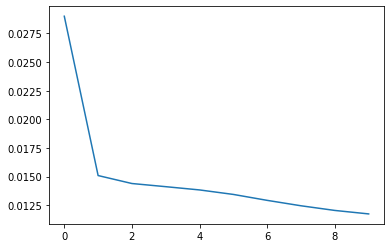

In [197]:
for k in range(epochs):
    localaccum = []
    for xy, conn, sda in iter(loader):
        i = i+1
        local_xy = Variable(xy)
        local_xy = local_xy.to(device)
        #print("local xy", local_xy)
        
        local_conn = Variable(conn)
        local_conn = local_conn.to(device)
        #print("local conn", local_conn)
        
        local_sda = Variable(sda)
        local_sda = local_sda.to(sda) 
        
        output,angles = model.forward(local_xy,local_conn, debug=False)
        output = output.to(device)
        
        #ang = np.arccos(np.clip(output.cpu().detach().numpy(), -1.0, 1.0))
        #ang = torch.from_numpy(np.asarray(ang,dtype=np.float32))
        #ang = torch.acos(output)
        #msda = torch.std(ang)
        #print("ang msda, sda ",ang, msda, local_sda)
        print("output", (output), "sda", local_sda)
        loss = criterion(output, local_sda)
        #print("network loss -> ", loss)
        #print(local_xy, local_xyz)
        #if (i%500 == 0): print("network loss -> ", loss)
        optimizer.zero_grad()
        #model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.item())
    train_accum.append(np.mean(localaccum))
    epoch_errors.append(localaccum)
plt.plot(train_accum);                      

In [189]:
epoch_e

[0.1379515528678894,
 0.1461912989616394,
 0.1450045108795166,
 0.14657697081565857,
 0.14384007453918457,
 0.16066017746925354,
 0.1225958988070488,
 0.16039350628852844,
 0.14687982201576233,
 0.1115851178765297,
 0.17717981338500977,
 0.05522620305418968,
 0.13717859983444214,
 0.09206589311361313,
 0.12864583730697632,
 0.13320159912109375,
 0.13495966792106628,
 0.08370539546012878,
 0.07036902010440826,
 0.0382491759955883,
 0.11566077917814255,
 0.08199790120124817,
 0.10268893092870712,
 0.11636542528867722,
 0.0549301952123642,
 0.08161196112632751,
 0.13235104084014893,
 0.11931810528039932,
 0.1256541907787323,
 0.05788934975862503,
 0.07306349277496338,
 0.08649109303951263,
 0.07725538313388824,
 0.09565693885087967,
 0.1415485143661499,
 0.06512311100959778,
 0.05819151550531387,
 0.12861362099647522,
 0.12418752163648605,
 0.08723927289247513,
 0.037984028458595276,
 0.05059913545846939,
 0.12457039207220078,
 0.010943736881017685,
 0.12488830834627151,
 0.12469974905252

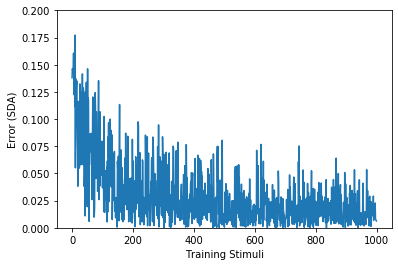

In [193]:
plt.xlabel("Training Stimuli")
plt.ylim(0,0.2)
plt.ylabel("Error (SDA)")
plt.plot(localaccum)

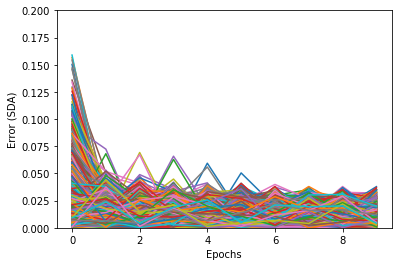

In [201]:
plt.xlabel("Epochs")
plt.ylim(0,0.2)
plt.ylabel("Error (SDA)")
plt.plot(epoch_errors)

In [57]:
print(list(model.parameters())[:])

[Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]]]), Parameter containing:
tensor([0., 0., 0.]), Parameter containing:
tensor([[[ 1., -1.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 1., -1.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 1., -1.]

In [58]:
model.show_grad()

# 0 conv net grads:  None None
# 1 conv net grads:  None None
# 2 conv net grads:  None None
# 3 conv net grads:  None None
# 4 conv net grads:  None None
# 5 conv net grads:  None None
# 6 conv net grads:  None None
# 7 conv net grads:  None None
# 8 conv net grads:  None None
# 9 conv net grads:  None None
# 10 conv net grads:  None None
# 11 conv net grads:  None None
# 12 conv net grads:  None None
# 13 conv net grads:  None None
# 14 conv net grads:  None None
# 15 conv net grads:  None None
# 16 conv net grads:  None None
# 17 conv net grads:  None None
# 18 conv net grads:  None None
other grads:  tensor([[ 3.2675e-04,  3.5716e-04, -3.1386e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.2933e-04,  1.4136e-04, -1.2423e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.3956e-04,  2.6186e-04, -2.3011e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-2.1464e-04, -2.3462e-04,  2.0618e-04,  ...,  0.0000e+00,

In [12]:
# nverts = 8
# model = DepthEstNet(nverts, nonlinearity=fn.sigmoid, additional_hidden_wide=1)


In [208]:
model.to(device)
msda = []
l2_norm = []
n = test_xyz_obj.shape[0]
for i in range(100):
    print(i)
    print("****************************************************")
    obj = torch.Tensor(test_xyz_obj[i].unsqueeze(0)).to(device)
    conn = torch.Tensor(test_xy_conn[i].unsqueeze(0)).to(device)
    output = model.forward(obj, conn, extract_z=True)
    print("Obj:", obj)
    print("Obj:", obj.shape)
    print("Conn:", conn)
    print("Conn:", conn.shape)
    print("Output:", output)
    #print("Z matrix shape:", output.shape)
    #print("Z coords:", output)
    #msda.append((output.std()))  
#     if (i == 0):
#         origin = output
#         #print(origin)
#     else:    
#         l2_norm.append(torch.norm(origin - output))
print(msda)        

0
****************************************************
Obj: tensor([[[ 0.8315,  0.8256,  0.8023,  0.8796, -0.7997, -0.8098, -0.8347,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0835, -0.0854,  0.0858, -0.0836, -0.0888,  0.0893, -0.0843,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.2221, -0.2428,  0.2134,  0.2372, -0.2298,  0.2265,  0.2256,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])
Obj: torch.Size([1, 3, 20])
Conn: tensor([[[1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 1., 1., 1.,

Obj: tensor([[[ 0.4897,  0.4862,  0.4725,  0.5180, -0.4710, -0.4769, -0.4915,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.6728, -0.6878,  0.6910, -0.6732, -0.7150,  0.7191, -0.6793,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.9822, -1.0736,  0.9435,  1.0489, -1.0161,  1.0013,  0.9974,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])
Obj: torch.Size([1, 3, 20])
Conn: tensor([[[1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 

Obj: tensor([[[ 0.5793,  0.5751,  0.5589,  0.6127, -0.5571, -0.5641, -0.5814,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3509, -0.3587,  0.3603, -0.3511, -0.3729,  0.3750, -0.3543,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.9299, -1.0164,  0.8932,  0.9930, -0.9619,  0.9479,  0.9443,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])
Obj: torch.Size([1, 3, 20])
Conn: tensor([[[1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 

Obj: tensor([[[ 0.7508,  0.7455,  0.7244,  0.7942, -0.7221, -0.7312, -0.7536,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.9823, -1.0041,  1.0088, -0.9828, -1.0439,  1.0499, -0.9918,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.1600, -0.1749,  0.1537,  0.1709, -0.1656,  0.1631,  0.1625,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])
Obj: torch.Size([1, 3, 20])
Conn: tensor([[[1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 

Obj: tensor([[[ 0.6209,  0.6165,  0.5990,  0.6568, -0.5971, -0.6047, -0.6232,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.8120, -0.8301,  0.8339, -0.8125, -0.8629,  0.8679, -0.8199,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.5588, -0.6108,  0.5368,  0.5967, -0.5781,  0.5696,  0.5675,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])
Obj: torch.Size([1, 3, 20])
Conn: tensor([[[1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 

Obj: tensor([[[ 0.1247,  0.1238,  0.1203,  0.1319, -0.1199, -0.1215, -0.1252,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0892, -0.0912,  0.0916, -0.0892, -0.0948,  0.0953, -0.0900,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.8593, -0.9392,  0.8253,  0.9176, -0.8889,  0.8759,  0.8726,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])
Obj: torch.Size([1, 3, 20])
Conn: tensor([[[1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 

Obj: tensor([[[ 0.6485,  0.6439,  0.6257,  0.6860, -0.6237, -0.6316, -0.6509,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.4902, -0.5011,  0.5034, -0.4905, -0.5209,  0.5239, -0.4949,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.3088, -0.3376,  0.2966,  0.3298, -0.3195,  0.3148,  0.3136,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])
Obj: torch.Size([1, 3, 20])
Conn: tensor([[[1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 

Obj: tensor([[[ 0.3380,  0.3356,  0.3261,  0.3575, -0.3250, -0.3291, -0.3392,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.4412, -0.4510,  0.4531, -0.4414, -0.4689,  0.4716, -0.4454,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.8691, -0.9499,  0.8348,  0.9280, -0.8990,  0.8859,  0.8825,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]])
Obj: torch.Size([1, 3, 20])
Conn: tensor([[[1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 

## Create Test Set

In [215]:
test_xy_obj = [] #torch.Tensor()
test_xyz_obj = []
test_xy_conn = []
test_xy_deg = [] 
test_xy_ang = []
test_xy_sda = []

objs = []

with open('test/cuboids/data.pickle.100.randomized.cuboids', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    if(i%5 > 0):
        continue
    obj = np.asarray(data[i])
    conn = np.asarray(data[i+1]) 
    deg = np.asarray(data[i+2]) 
    angs = np.asarray(data[i+3]) 
    sda = np.asarray(data[i+4]) 
    print("obj: ", obj)
    print("obj shape: ", obj.shape)
    objs.append(np.copy(obj))
    
    print("deg: ", deg)
    deg = torch.from_numpy(np.asarray(deg,dtype=np.float32))
    deg = deg.unsqueeze(0)
    test_xy_deg.append(deg)
    
    print("ang: ", angs)
    angs = torch.from_numpy(np.asarray(angs,dtype=np.float32))
    angs = angs.unsqueeze(0)
    test_xy_ang.append(angs)
    
    
    print("sda: ", sda)
    sda = torch.from_numpy(np.asarray(sda,dtype=np.float32))
    sda = sda.unsqueeze(0)
    test_xy_sda.append(sda)
    
    
    #test_xyz_obj.append(torch.from_numpy(np.asarray(obj,dtype=np.float32)).unsqueeze(0))  
    
    vv = obj.shape[1]
    print("vv: ",vv)
    #obj[2,0:vv]=0
    vverts = torch.from_numpy(np.asarray(obj,dtype=np.float32))
    vverts = vverts.unsqueeze(0)
    pad = nverts - vv
    m = nn.ZeroPad2d((0, pad, 0, 0)) #padding(left,right,top,bottom)
    x = m(vverts)
    test_xyz_obj.append(x)   
    
    
    
    conn = torch.from_numpy(np.asarray(conn,dtype=np.float32))
    conn = conn.unsqueeze(0)
    print("conn: ", conn)
    print("conn shape: ", conn.shape)
    conn_mat = restructure_conn_mat(8-vv,vv,conn)
#    print("hidden conn mat: ", conn_mat)
    print("restrcutured conn shape: ", conn_mat.shape)
    conn_mat = expand_conn_mat(nverts,8,conn_mat)
#     print("expanded conn mat: ", conn_mat)  
    print("conn shape: ", conn_mat.shape)
    test_xy_conn.append(conn_mat)


# test_xy_obj = torch.cat(test_xy_obj)
# print(test_xy_obj.shape)

test_xyz_obj = torch.cat(test_xyz_obj)
print(test_xyz_obj.shape)

test_xy_conn = torch.cat(test_xy_conn)
print(test_xy_conn.shape)

# test_xy_deg = torch.cat(test_xy_deg)
# print(test_xy_deg.shape)

# test_xy_ang = torch.cat(test_xy_ang)
# print(test_xy_ang.shape)

test_xy_sda = torch.cat(test_xy_sda)
print(test_xy_sda.shape)

obj:  [[ 0.38948041  0.35108331  0.19937113  0.70195544 -0.18261468 -0.24825585
  -0.40972167]
 [ 0.33079463 -0.42807031  0.44890308 -0.33299804 -0.60562313  0.63247478
  -0.37295443]
 [-0.44591764 -0.99507928  0.21298422  0.84660506 -0.64945656  0.56045008
   0.53737855]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [0.89313143 2.00755429 2.12865186 1.85933006 1.42634189 1.93015862
 2.08238053 1.07414627 2.06795716 1.36390352 1.86587524 1.39173186
 1.74307275 1.81175673]
sda:  0.37834907677818624
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.64304173  0.60852033  0.4721216

conn shape:  torch.Size([1, 3, 190])
obj:  [[ 0.18277133  0.15729488  0.05663402  0.39009818 -0.04551616 -0.08906897
  -0.19620137]
 [ 0.83098137 -1.16970193  1.24223399 -0.83865011 -1.78792667  1.88142169
  -0.97777826]
 [-0.38810021 -1.05019581  0.10727035  0.87118512 -0.6335004   0.52619076
   0.49836886]]
obj shape:  (3, 7)
deg:  [2 3 3 3 2 2 3]
ang:  [0.74407893 2.23853111 2.25806808 2.03376436 1.53638673 1.76441979
 2.19525218 0.95479023 2.16777873 1.32887709 2.02324963 1.32619929
 1.78030014 1.85888112]
sda:  0.4689340333041197
vv:  7
conn:  tensor([[[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
          1., 0., 0., 0.]]])
conn shape:  torch.Size([1, 3, 21])
restrcutured conn shape:  torch.Size([1, 3, 28])
conn shape:  torch.Size([1, 3, 190])
obj:  

In [218]:
model.to(device)
msda = []
l2_norm = []
n = train_xyz_obj.shape[0]
test_errors = []
for i in range(100):
    print(i)
    print("****************************************************")
    obj = torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device)
    conn = torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device)
    output,ang = model.forward(obj, conn)
#     print("Obj:", obj)
#     print("Obj:", obj.shape)
#     print("Conn:", conn)
#     print("Conn:", conn.shape)
    print("Output:", output)
    #print("Z matrix shape:", output.shape)
    #print("Z coords:", output)
    #msda.append((output.std())) 
    test_errors.append(output)
           

0
****************************************************
Output: tensor(0.0349, grad_fn=<StdBackward0>)
1
****************************************************
Output: tensor(0.0535, grad_fn=<StdBackward0>)
2
****************************************************
Output: tensor(0.0536, grad_fn=<StdBackward0>)
3
****************************************************
Output: tensor(0.0223, grad_fn=<StdBackward0>)
4
****************************************************
Output: tensor(0.0443, grad_fn=<StdBackward0>)
5
****************************************************
Output: tensor(0.0291, grad_fn=<StdBackward0>)
6
****************************************************
Output: tensor(0.0484, grad_fn=<StdBackward0>)
7
****************************************************
Output: tensor(0.0436, grad_fn=<StdBackward0>)
8
****************************************************
Output: tensor(0.0503, grad_fn=<StdBackward0>)
9
****************************************************
Output: tensor(0.0360, grad

Output: tensor(0.0450, grad_fn=<StdBackward0>)
90
****************************************************
Output: tensor(0.0579, grad_fn=<StdBackward0>)
91
****************************************************
Output: tensor(0.0444, grad_fn=<StdBackward0>)
92
****************************************************
Output: tensor(0.0456, grad_fn=<StdBackward0>)
93
****************************************************
Output: tensor(0.0365, grad_fn=<StdBackward0>)
94
****************************************************
Output: tensor(0.0276, grad_fn=<StdBackward0>)
95
****************************************************
Output: tensor(0.0150, grad_fn=<StdBackward0>)
96
****************************************************
Output: tensor(0.0287, grad_fn=<StdBackward0>)
97
****************************************************
Output: tensor(0.0534, grad_fn=<StdBackward0>)
98
****************************************************
Output: tensor(0.0312, grad_fn=<StdBackward0>)
99
***********************

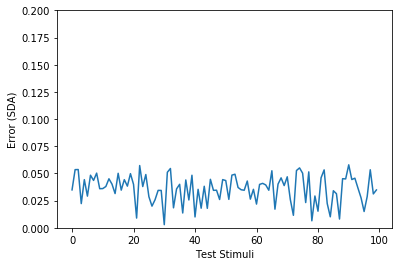

In [219]:
plt.xlabel("Test Stimuli")
plt.ylim(0,0.2)
plt.ylabel("Error (SDA)")
plt.plot(test_errors)

## Test a cubiod obj from trained model

In [123]:
i=6

In [124]:
obj = objs[i]

x = obj[0]
y = obj[1]
z = obj[2]

trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')



In [127]:

obj = objs[i]

x = obj[0]
y = obj[1]
z = obj[2]

x_recovered, y_recovered, z_recovered,sda = model.forward(torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device), extract_z=True)
    
#x=x_recovered.detach().tolist()[0]
#y=y_recovered.detach().tolist()[0]
z=z_recovered.detach().tolist()[0]
    
    
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')



## Test SDA consistency for different orientations


In [134]:
# New_Stimuli_Block_Objects_v1.py (New_Stimuli_Block_Objects_v1_DONOTCHANGE.py)
# Block Object

def test_block_objs(block, obj):
    test_xy_Block_obj = []
    test_xy_Block_conn = []
    objs = []
    n_params = 5
    nverts = 20
    
    fname = "test/Block" + str(block) + "/Obj" + str(obj) + "/data.pickle"

    
    try:
        with open(fname, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        return

    for i in range(len(data)):
    #     if(i%n_params > 0):
    #         continue
        full_obj = np.asarray(data[i])

        obj = full_obj[0]

        print("Obj: ", obj)

        vv = obj.shape[1]
        print("vverts:",vv)
        objs.append(np.copy(obj))

        obj[2,0:vv]= np.random.rand(vv)
        vverts = torch.from_numpy(np.asarray(obj,dtype=np.float32))
        vverts = vverts.unsqueeze(0)
        pad = nverts - vv
        m = nn.ZeroPad2d((0, pad, 0, 0))
        x = m(vverts)
        test_xy_Block_obj.append(x)    

        conn = full_obj[1] #np.asanyarray(data[i+1])    
        print("Conn", conn)
        conn = torch.from_numpy(np.asarray(conn,dtype=np.float32))
        conn = conn.unsqueeze(0)
        conn_mat = expand_conn_mat(nverts,vv,conn)

    #     conn_mat = restructure_conn_mat(3,vv,conn)
    #     print("hidden conn mat: ", conn_mat)
    #     print("conn shape: ", conn_mat.shape)
    #     conn_mat = expand_conn_mat(nverts,vv,conn_mat)
    #     print("expanded conn mat: ", conn_mat)  
    #     print("conn shape: ", conn_mat.shape)

        print("vverts:",vv)
        conn_mat = restructure_conn_mat(nverts-vv,vv,conn)
    #   print("hidden conn mat: ", conn_mat)
        print("restrcutured conn shape: ", conn_mat.shape)
    #    conn_mat = expand_conn_mat(nverts,vv,conn_mat)
    #   print("expanded conn mat: ", conn_mat)  
        print("conn shape: ", conn_mat.shape)
        test_xy_Block_conn.append(conn_mat)


    test_xy_Block_obj = torch.cat(test_xy_Block_obj)
    test_xy_Block_conn = torch.cat(test_xy_Block_conn)

    print(test_xy_Block_obj.shape)
    print(test_xy_Block_conn.shape)

    from numpy import linalg as LA
    msda = []
    l2_norm = []
    n = test_xy_Block_obj.shape[0]
    
    for i in range(n):
        print(i)
        obj = torch.Tensor(test_xy_Block_obj[i].unsqueeze(0)).to(device)
        conn = torch.Tensor(test_xy_Block_conn[i].unsqueeze(0)).to(device)
        sda, output = model.forward(obj, conn)
        print(output)
        msda.append(torch.norm(output))  
        zero_tensor = torch.Tensor.new_zeros(output, output.size())
        if (i == 0):
            origin = output
            
            print(origin)
        else:    
            l2_norm.append(torch.norm(zero_tensor - output))


    l2_norm = torch.stack(l2_norm,dim=0)
    print("l2 norm diffs:", l2_norm)
    print("l2 norm diffs mean:", torch.mean(l2_norm))
    print("l2 norm std:", torch.std(l2_norm))
    
    stats = {"mean":torch.mean(l2_norm).item(), "std": torch.std(l2_norm).item(), "norms": l2_norm.tolist()[:]}
    

    # msda = torch.stack(msda,dim=0)
    # print("msda: ", msda)
    # print("msda mean: ", torch.mean(msda))
    # print("msda std:", torch.std(msda))
    
    return stats

In [135]:
Block = {}
for b in [1,2,3,4,5,6,7]:
    Obj_norms = {}
    for o in [1,2,3]:
        Obj_norms[o]=test_block_objs(b,o)
    Block[b]=Obj_norms    

Obj:  [[-6.87655509e-01  6.23361945e-01 -6.23361945e-01  6.87655509e-01
  -6.87655509e-01  2.22763434e-01  0.00000000e+00  7.11153030e-01
  -7.11153030e-01  6.23361945e-01  6.87655509e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.45393574e-01  6.78522706e-01  6.78517461e-01 -7.45393574e-01
  -7.45399654e-01  7.23349929e-01 -7.35724926e-01 -6.90116763e-01
  -6.90116763e-01  6.78517461e-01 -7.45399654e-01 -8.28363955e-01
   7.77468741e-01 -8.28369677e-01]
 [-8.41634631e-01 -7.22080410e-01  7.22085297e-01 -8.41634631e-01
   8.41629267e-01  2.61851960e-06 -2.66331699e-06 -2.43861132e-06
  -2.43861132e-06  7.22085297e-01  8.41629267e-01 -7.87905872e-01
   6.25736475e-01  7.87899911e-01]]
vverts: 14
Conn [[1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
  0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
  0 0 1 0 1 1 1

tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.8708, 3.9863, 0.8120],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.1157, 0.0615],
         [0.0000, 0.0000, 0.0000,  ..., 3.1157, 0.0134, 3.1743],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
3
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.4437, 3.7456, 0.4169],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.3025, 0.0355],
         [0.0000, 0.0000, 0.0000,  ..., 3.3025, 0.0134, 3.3287],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
4
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.5029, 3.6832, 0.4843],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.6096, 4.6445, 0.6135],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 4.0351, 0.0169],
         [0.0000, 0.0000, 0.0000,  ..., 4.0351, 0.0134, 4.0310],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
8
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.7561, 4.2640, 0.7596],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.5081, 0.0188],
         [0.0000, 0.0000, 0.0000,  ..., 3.5081, 0.0134, 3.5044],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
l2 norm diffs: tensor([280.5557, 268.2152, 267.9312, 276.0790, 301.9755, 266.4121, 279.5533,
        292.1018], grad_fn=<Sta

tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.6414, 4.0345, 0.6534],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.3932, 0.0156],
         [0.0000, 0.0000, 0.0000,  ..., 3.3932, 0.0134, 3.3811],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
2
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.9016, 4.8223, 0.8582],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.9216, 0.0581],
         [0.0000, 0.0000, 0.0000,  ..., 3.9216, 0.0134, 3.9641],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
3
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.5158, 5.0730, 0.5051],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

tensor([[[0.0134, 0.0000, 0.0000,  ..., 1.0394, 4.6357, 1.0479],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.5967, 0.0291],
         [0.0000, 0.0000, 0.0000,  ..., 3.5967, 0.0134, 3.5878],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
7
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.8507, 4.9680, 0.8549],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 4.1174, 0.0134],
         [0.0000, 0.0000, 0.0000,  ..., 4.1174, 0.0134, 4.1131],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
8
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.8306, 4.8720, 0.8369],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.9152, 3.7621, 0.8856],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 2.8499, 0.0740],
         [0.0000, 0.0000, 0.0000,  ..., 2.8499, 0.0134, 2.8765],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.9152, 3.7621, 0.8856],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 2.8499, 0.0740],
         [0.0000, 0.0000, 0.0000,  ..., 2.8499, 0.0134, 2.8765],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
1
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.7217, 2.9948, 0.7632],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0

tensor([[[0.0134, 0.0000, 0.0000,  ..., 1.3776, 4.8833, 1.3708],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.5068, 0.0523],
         [0.0000, 0.0000, 0.0000,  ..., 3.5068, 0.0134, 3.5125],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
6
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.9665, 5.5400, 0.9437],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 4.5735, 0.0232],
         [0.0000, 0.0000, 0.0000,  ..., 4.5735, 0.0134, 4.5962],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
7
tensor([[[0.0134, 0.0000, 0.0000,  ..., 1.2137, 4.7963, 1.2145],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

restrcutured conn shape:  torch.Size([1, 3, 190])
conn shape:  torch.Size([1, 3, 190])
Obj:  [[-1.17742276e+00  6.11078918e-01  2.35430389e-06  3.54226232e-01
  -3.54230881e-01  6.62939191e-01 -9.75813985e-01  1.17741811e+00
   9.75805640e-01  2.29535893e-01 -3.52957090e-06 -2.29542956e-01
   4.34512615e-01 -4.34516609e-01]
 [-7.92631209e-01  6.85629427e-01  8.03891599e-01 -7.92638004e-01
  -7.92631209e-01 -8.53517830e-01 -1.42882764e+00 -7.92638004e-01
  -1.42883646e+00 -1.20437980e+00 -1.20519376e+00 -1.20437980e+00
  -7.00903654e-01 -7.00903654e-01]
 [ 1.01074995e-02  4.43974823e-01  1.71050181e-06  1.12291563e+00
  -1.12291896e+00  4.81653512e-01 -7.08970308e-01 -1.01108728e-02
   7.08964229e-01 -3.15936476e-01 -2.56438329e-06  3.15931350e-01
  -5.98059475e-01  5.98056614e-01]]
vverts: 14
Conn [[1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0
  1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [

tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.4108, 4.5721, 0.3986],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 4.1617, 0.0218],
         [0.0000, 0.0000, 0.0000,  ..., 4.1617, 0.0134, 4.1734],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
4
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.7741, 4.1705, 0.7301],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.3968, 0.0502],
         [0.0000, 0.0000, 0.0000,  ..., 3.3968, 0.0134, 3.4404],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
5
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.7959, 4.4464, 0.8007],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

tensor([[[0.0134, 0.0000, 0.0000,  ..., 1.0537, 4.3837, 1.0601],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.3314, 0.0515],
         [0.0000, 0.0000, 0.0000,  ..., 3.3314, 0.0134, 3.3236],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
l2 norm diffs: tensor([283.4682, 265.5058, 265.6332, 286.9924, 296.2959, 276.1026, 278.4261,
        289.2234], grad_fn=<StackBackward>)
l2 norm diffs mean: tensor(280.2060, grad_fn=<MeanBackward0>)
l2 norm std: tensor(10.9894, grad_fn=<StdBackward0>)
Obj:  [[-6.87655509e-01 -6.23361945e-01 -6.87655509e-01  6.23361945e-01
   6.87655509e-01  6.23361945e-01  6.87655509e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  7.11153030e-01
   3.57987493e-01 -7.11153030e-01]
 [-7.45393574e-01  6.78517461e-01 -7.45399654e-01  6.78522706e-01
  -7.4

tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.7657, 4.8071, 0.7552],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 4.0415, 0.0174],
         [0.0000, 0.0000, 0.0000,  ..., 4.0415, 0.0134, 4.0519],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
3
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.8069, 4.7161, 0.7729],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.9092, 0.0345],
         [0.0000, 0.0000, 0.0000,  ..., 3.9092, 0.0134, 3.9432],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
4
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.9467, 3.7322, 0.9722],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

tensor([[[0.0134, 0.0000, 0.0000,  ..., 1.2759, 4.8912, 1.2840],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0134,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 3.6157, 0.0290],
         [0.0000, 0.0000, 0.0000,  ..., 3.6157, 0.0134, 3.6073],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
8
tensor([[[0.0134, 0.0000, 0.0000,  ..., 0.8638, 4.9528, 0.8651],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0134, 4.0890, 0.0134],
         [0.0000, 0.0000, 0.0000,  ..., 4.0890, 0.0134, 4.0877],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0134]]],
       grad_fn=<MulBackward0>)
l2 norm diffs: tensor([268.4111, 269.6159, 278.1023, 292.3765, 248.6439, 280.2941, 276.6451,
        301.3352], grad_fn=<Sta

In [136]:
Block

{1: {1: {'mean': 283.216552734375,
   'std': 12.323619842529297,
   'norms': [288.31488037109375,
    269.28729248046875,
    265.85748291015625,
    286.21514892578125,
    296.3350830078125,
    273.5530090332031,
    287.0635070800781,
    299.1060485839844]},
  2: {'mean': 278.19183349609375,
   'std': 8.502881050109863,
   'norms': [274.0878601074219,
    270.1759033203125,
    273.7192077636719,
    283.58404541015625,
    294.41680908203125,
    271.3304748535156,
    273.4577331542969,
    284.7626037597656]},
  3: {'mean': 279.10296630859375,
   'std': 12.58110523223877,
   'norms': [280.55572509765625,
    268.2152404785156,
    267.9311828613281,
    276.0789794921875,
    301.9754943847656,
    266.4120788574219,
    279.5533447265625,
    292.1017761230469]}},
 2: {1: {'mean': 261.009521484375,
   'std': 8.587808609008789,
   'norms': [247.22621154785156,
    265.1329345703125,
    256.51654052734375,
    266.6097412109375,
    270.0853576660156,
    251.21763610839844,
  

In [147]:
import operator
def keyfunc(tup):
    key, d = tup

    sub_key1 = d[1]["std"]
    sub_key2 = d[2]["std"]
    try:
        sub_key3 = d[3]["std"]
    except:
        avg_std = (sub_key1 + sub_key2)/2
    else:
        avg_std = (sub_key1 + sub_key2 + sub_key3)/2
        
    print(key)
    print(avg_std)
    return avg_std



items = sorted(Block.items(), key = keyfunc)
for b in items:
    print("\n Block: ", b[0])

1
16.703803062438965
2
18.165359497070312
3
14.421209812164307
4
28.713955879211426
5
33.23077583312988
6
10.29278564453125
7
26.14410638809204

 Block:  6

 Block:  3

 Block:  1

 Block:  2

 Block:  7

 Block:  4

 Block:  5


In [148]:
avg_std_blocks = [
16.703803062438965,
18.165359497070312,
14.421209812164307,
28.713955879211426,
33.23077583312988,
10.29278564453125,
26.14410638809204]

<BarContainer object of 7 artists>

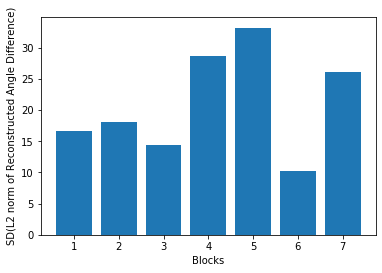

In [158]:
plt.xlabel("Blocks")
plt.ylabel("SD(L2 norm of Reconstructed Angle Difference)")
plt.bar([1,2,3,4,5,6,7],avg_std_blocks)

## Test Experiment Object Reconstruction

In [164]:
# New_Stimuli_Block_Objects_v1.py (New_Stimuli_Block_Objects_v1_DONOTCHANGE.py)
# Block Object

def test_block_objs_z_recovery(block, obj):
    test_xy_Block_obj = []
    test_xy_Block_conn = []
    objs = []
    n_params = 5
    nverts = 20
    
    fname = "test/Block" + str(block) + "/Obj" + str(obj) + "/data.pickle"

    
    try:
        with open(fname, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        return

    for i in range(len(data)):
    #     if(i%n_params > 0):
    #         continue
        full_obj = np.asarray(data[i])

        obj = full_obj[0]

        #print("Obj: ", obj)

        vv = obj.shape[1]
        #print("vverts:",vv)
        objs.append(np.copy(obj))

        obj[2,0:vv]= np.random.rand(vv)
        vverts = torch.from_numpy(np.asarray(obj,dtype=np.float32))
        vverts = vverts.unsqueeze(0)
        pad = nverts - vv
        m = nn.ZeroPad2d((0, pad, 0, 0))
        x = m(vverts)
        test_xy_Block_obj.append(x)    

        conn = full_obj[1] #np.asanyarray(data[i+1])    
        #print("Conn", conn)
        conn = torch.from_numpy(np.asarray(conn,dtype=np.float32))
        conn = conn.unsqueeze(0)
        conn_mat = expand_conn_mat(nverts,vv,conn)

    #     conn_mat = restructure_conn_mat(3,vv,conn)
    #     print("hidden conn mat: ", conn_mat)
    #     print("conn shape: ", conn_mat.shape)
    #     conn_mat = expand_conn_mat(nverts,vv,conn_mat)
    #     print("expanded conn mat: ", conn_mat)  
    #     print("conn shape: ", conn_mat.shape)

        #print("vverts:",vv)
        conn_mat = restructure_conn_mat(nverts-vv,vv,conn)
    #   print("hidden conn mat: ", conn_mat)
        #print("restrcutured conn shape: ", conn_mat.shape)
    #    conn_mat = expand_conn_mat(nverts,vv,conn_mat)
    #   print("expanded conn mat: ", conn_mat)  
        #print("conn shape: ", conn_mat.shape)
        test_xy_Block_conn.append(conn_mat)


    test_xy_Block_obj = torch.cat(test_xy_Block_obj)
    test_xy_Block_conn = torch.cat(test_xy_Block_conn)

    print(test_xy_Block_obj.shape)
    print(test_xy_Block_conn.shape)


    n = test_xy_Block_obj.shape[0]
    
    for i in range(n):
        print(i)
        obj = torch.Tensor(test_xy_Block_obj[i].unsqueeze(0)).to(device)
        conn = torch.Tensor(test_xy_Block_conn[i].unsqueeze(0)).to(device)
        sda, output = model.forward(obj, conn)
        x_recovered, y_recovered, z_recovered, sda = model.forward(torch.Tensor(test_xy_Block_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(test_xy_Block_conn[i].unsqueeze(0)).to(device), extract_z=True, debug=False)
        
        print(i, "z_recovered", z_recovered, "sda", sda)

    
    stats = {"z recovered":z_recovered.detach().tolist()[0]}

    
    return stats

In [165]:
for b in [1]:
    Obj_norms = {}
    for o in [1]:
        Obj_norms[o]=test_block_objs_z_recovery(b,o)
   

torch.Size([9, 3, 20])
torch.Size([9, 3, 190])
0
0 z_recovered tensor([[ 3.7940,  0.8128,  3.1129, -1.2307,  0.6184, -2.2153, -2.0315, -4.0558,
         -0.1417, -0.0887, -0.5519, -0.5729, -0.1001, -0.2279, -0.1729, -0.2577,
         -0.0467, -0.1112,  0.0233,  0.1196]], grad_fn=<AddmmBackward>) sda tensor(1.3281, grad_fn=<StdBackward0>)
1
1 z_recovered tensor([[ 4.4059,  0.6198,  3.5719, -1.4717,  0.5371, -2.4025, -2.4001, -4.7179,
         -0.1745, -0.1356, -0.6413, -0.5863, -0.0723, -0.2012, -0.1921, -0.3762,
         -0.0400, -0.1766,  0.0107,  0.1456]], grad_fn=<AddmmBackward>) sda tensor(1.4403, grad_fn=<StdBackward0>)
2
2 z_recovered tensor([[ 4.2744,  0.7316,  3.3594, -1.4858,  0.5234, -2.3603, -2.2367, -4.5260,
         -0.1634, -0.0728, -0.6238, -0.5938, -0.0416, -0.2592, -0.1632, -0.3378,
         -0.0818, -0.1827,  0.0464,  0.1428]], grad_fn=<AddmmBackward>) sda tensor(1.3682, grad_fn=<StdBackward0>)
3
3 z_recovered tensor([[ 4.3786,  0.7427,  3.4338, -1.6315,  0.8462, -2.7

## Test Block Objects by Rendering

In [304]:
i=2

obj = torch.Tensor(test_xy_Block_obj[i].unsqueeze(0)).to(device).tolist()[0]
conn = torch.Tensor(test_xy_Block_conn[i].unsqueeze(0)).to(device).tolist()[0]


In [305]:

x = obj[0]
y = obj[1]
z = obj[2]

trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

# print(x,"\n\n",y,"\n\n",z)
# trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
# py.iplot([trace])

In [135]:
x_recovered, y_recovered, z_recovered, sda = model.forward(torch.Tensor(test_xy_Block_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(test_xy_Block_conn[i].unsqueeze(0)).to(device), extract_z=True, debug=True)
    
x=x_recovered.detach().tolist()[0]
y=y_recovered.detach().tolist()[0]
z=z_recovered.detach().tolist()[0]
    
print(x,"\n\n",y,"\n\n",z)

# trace = go.Scatter3d(
#     x=x,
#     y=y,
#     z=z,
#     mode='markers',
#     marker=dict(
#         size=12,
#         line=dict(
#             color='rgb(204, 204, 204)',
#             width=0.5
#         ),
#         opacity=0.8
#     )
# )

# data = [trace]
# layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='simple-3d-scatter')

trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
py.iplot([trace])


initial xyz tensor([[[-9.1408e-01,  3.6972e-01, -3.6972e-01,  3.9392e-01, -3.9392e-01,
          -8.2301e-07,  6.7635e-01, -6.7635e-01,  8.1599e-01,  9.1408e-01,
          -2.4348e-01,  1.9336e-01,  2.4347e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-7.4539e-01,  6.7852e-01,  6.7852e-01, -7.4539e-01, -7.4540e-01,
          -7.3572e-01, -6.9012e-01, -6.9012e-01,  6.7852e-01, -7.4540e-01,
          -8.2836e-01,  7.7747e-01, -8.2837e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.7041e-01,  6.7331e-01,  2.7965e-01,  4.8997e-01,  1.4759e-01,
           2.5530e-01,  1.3449e-01,  7.8992e-01,  1.2510e-01,  3.5964e-01,
           6.2605e-01,  8.0178e-01,  7.7174e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]])
initial z tensor([[0.5704, 0.6733, 0.2797, 0.4900, 0.1476, 0.2553, 0.1345, 0.7899, 

In [1505]:
import plotly.graph_objs as go

def plot_obj(i,objs):
    obj = objs[i]

    x = obj[0]
    y = obj[1]
    z = obj[2]

    print(x,y,z)

    # trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
    # py.iplot([trace])

    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=12,
            line=dict(
                color='rgb(204, 204, 204)',
                width=0.5
            ),
            opacity=0.8
        )
    )

    data = [trace]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='simple-3d-scatter')
    
    
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
    
def test_reconstruct(N, objs):
    print(N)
    print("******************************")
    fig = plt.figure()
    ax = Axes3D(fig)

    test_obj=objs[N]



    print("_________ORIG________")

    x=test_obj[0]
    y=test_obj[1]
    z=test_obj[2]

    verts = [list(zip(x, y,z))]
    print(verts)
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='b', marker='o')
    #lt.show()

    
    print("_________RECONST________")

    x_recovered, y_recovered, z_recovered = model.forward(torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device), extract_z=True)
    
    x=x_recovered.detach().tolist()[0]
    y=y_recovered.detach().tolist()[0]
    z=z_recovered.detach().tolist()[0]

    verts = [list(zip(x, y,z))]
    print(verts)
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()
    
    

1
******************************
_________ORIG________
[[(0.7357309460639954, 0.979057788848877, -0.7663657665252686), (0.7305053472518921, -1.0007728338241577, -0.8376749753952026), (0.7098585367202759, 1.0054240226745605, 0.7361288070678711), (0.778256356716156, -0.9795495867729187, 0.8183904886245728), (-0.7075781226158142, -1.0404164791107178, -0.7927998304367065), (-0.7165113687515259, 1.0464118719100952, 0.7812433838844299), (-0.73848557472229, -0.9884710907936096, 0.7782409191131592)]]
_________RECONST________
[[(0.7091562747955322, 0.45165756344795227, -0.5159934163093567), (0.7438804507255554, 0.7329924702644348, 1.1885387897491455), (0.7211530804634094, 0.507182240486145, 2.6391191482543945), (0.7616884112358093, -0.563785195350647, -1.9438837766647339), (-0.7053310871124268, -0.052126992493867874, 2.020890474319458), (-0.7216148972511292, -0.5102074146270752, -0.688231348991394), (-0.7538034915924072, -0.03737351670861244, 0.37119221687316895), (-0.015328340232372284, 0.0473

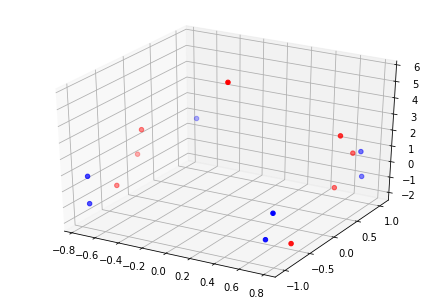

2
******************************
_________ORIG________
[[(0.8100869655609131, 0.9744318127632141, -0.8263795971870422), (0.8043333292007446, -0.9960437417030334, -0.9032723903656006), (0.7815998196601868, 1.0006730556488037, 0.7937742471694946), (0.856910228729248, -0.9749213457107544, 0.8824783563613892), (-0.7790889143943787, -1.035500168800354, -0.8548831343650818), (-0.7889249920845032, 1.0414671897888184, 0.8424216508865356), (-0.8131200671195984, -0.9838007092475891, 0.8391847014427185)]]
_________RECONST________
[[(0.8342768549919128, 0.46052682399749756, -0.5308156609535217), (0.791858434677124, 0.7239203453063965, 1.2254654169082642), (0.7712138891220093, 0.500069260597229, 2.7224879264831543), (0.8719741702079773, -0.5542609691619873, -1.992733120918274), (-0.781020998954773, -0.05278780311346054, 2.096564292907715), (-0.784159243106842, -0.5056627988815308, -0.7082254886627197), (-0.7989586591720581, -0.03081449121236801, 0.3813888728618622), (0.0140080526471138, 0.053501009

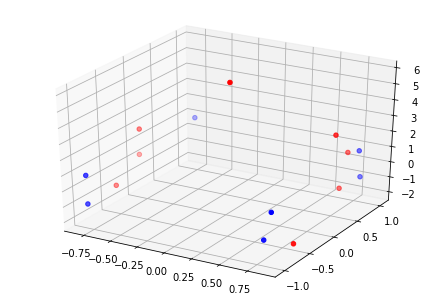

3
******************************
_________ORIG________
[[(0.14912953972816467, 0.3560808598995209, -0.48021262884140015), (0.1480703502893448, -0.3639770448207855, -0.5248937606811523), (0.1438853144645691, 0.36566877365112305, 0.4612639546394348), (0.1577492654323578, -0.3562597930431366, 0.5128117799758911), (-0.14342308044433594, -0.3783954083919525, -0.4967745244503021), (-0.14523380994796753, 0.38057592511177063, 0.48953312635421753), (-0.14968790113925934, -0.35950449109077454, 0.4876537024974823)]]
_________RECONST________
[[(0.1534663438796997, 0.16819466650485992, -0.41675737500190735), (0.14584219455718994, 0.2645912766456604, 0.9986913204193115), (0.14202256500720978, 0.18277566134929657, 2.2303733825683594), (0.16044935584068298, -0.202598437666893, -1.6933242082595825), (-0.1437768191099167, -0.019288543611764908, 1.6575613021850586), (-0.14438283443450928, -0.18480202555656433, -0.5873022079467773), (-0.14715665578842163, -0.011320505291223526, 0.33912938833236694), (0.00

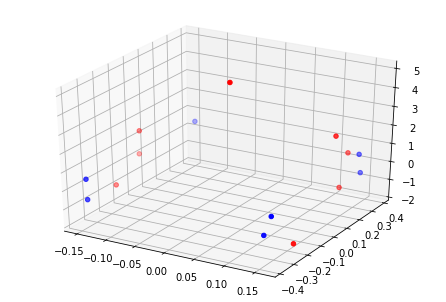

4
******************************
_________ORIG________
[[(0.8735414147377014, 0.6521538496017456, -0.8981115221977234), (0.8673370480537415, -0.6666153073310852, -0.9816757440567017), (0.842822790145874, 0.6697137355804443, 0.8626730442047119), (0.9240323305130005, -0.6524815559387207, 0.9590796828269958), (-0.8401152491569519, -0.6930222511291504, -0.9290861487388611), (-0.8507217764854431, 0.6970157623291016, 0.9155430197715759), (-0.8768120408058167, -0.6584240794181824, 0.9120281338691711)]]
_________RECONST________
[[(0.846450924873352, 0.30109184980392456, -0.5596979260444641), (0.8811976313591003, 0.48816874623298645, 1.2750370502471924), (0.8544031381607056, 0.33774563670158386, 2.826547145843506), (0.9071515798568726, -0.37538793683052063, -2.0580122470855713), (-0.8378908634185791, -0.034758612513542175, 2.187974214553833), (-0.855997622013092, -0.3398178219795227, -0.7343284487724304), (-0.8925846815109253, -0.02478451281785965, 0.38706931471824646), (-0.015650808811187744, 

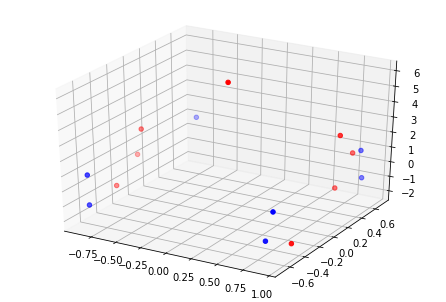

5
******************************
_________ORIG________
[[(0.9323145151138306, 0.016078101471066475, -0.030132709071040154), (0.9256927371025085, -0.016434570774435997, -0.03293634206056595), (0.8995291590690613, 0.016510963439941406, 0.028943661600351334), (0.9862025380134583, -0.016086183488368988, 0.03217826038599014), (-0.8960255980491638, 0.01678621396422386, -0.02918456308543682), (-0.8966394066810608, -0.0170856025069952, -0.031171899288892746), (-0.9079595804214478, 0.0171840600669384, 0.030717510730028152), (-0.9358052611351013, -0.0162326879799366, 0.030599625781178474)]]
_________RECONST________
[[(0.9907093644142151, 0.0007494017481803894, -0.31039249897003174), (0.8955610394477844, 1.7352402210235596e-05, 0.7236607670783997), (0.8743758797645569, -0.0034763822332024574, 1.6070873737335205), (1.0225180387496948, -0.019372202455997467, -1.3266907930374146), (-0.9006894826889038, -0.0020510517060756683, 1.0904757976531982), (-0.8850939869880676, 0.001566404476761818, -0.437345

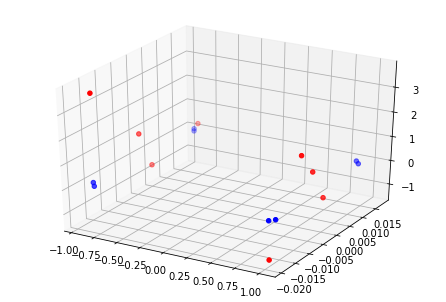

6
******************************
_________ORIG________
[[(0.9382349252700806, 0.7650790214538574, -0.8661271333694458), (0.9315710663795471, -0.7820460796356201, -0.94671630859375), (0.9052413702011108, 0.7856808304786682, 0.8319516181945801), (0.9924651384353638, -0.7654634118080139, 0.9249240756034851), (-0.9023332595825195, -0.8130254745483398, -0.8959996104240417), (-0.9137253165245056, 0.8177105188369751, 0.882938802242279), (-0.941747784614563, -0.7724350094795227, 0.8795480728149414)]]
_________RECONST________
[[(0.8664807081222534, 0.34568434953689575, -0.6210853457450867), (0.9681351780891418, 0.5765523314476013, 1.2908170223236084), (0.9358209371566772, 0.399454802274704, 2.811631917953491), (0.9477345943450928, -0.44508999586105347, -2.075037956237793), (-0.8963690996170044, -0.04015248268842697, 2.153269052505493), (-0.9276152849197388, -0.40012460947036743, -0.737330436706543), (-0.9834020733833313, -0.03346091881394386, 0.3410940170288086), (-0.04089125990867615, 0.032866

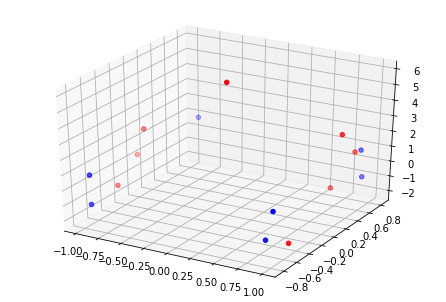

7
******************************
_________ORIG________
[[(0.9759292602539062, 0.5674376487731934, -0.9607089161872864), (0.9689976572990417, -0.5800191760063171, -1.0500965118408203), (0.9416101574897766, 0.5827152132987976, 0.9227994084358215), (1.0323381423950195, -0.5677228569984436, 1.0259264707565308), (-0.9385852217674255, -0.6029958128929138, -0.9938414692878723), (-0.9504349827766418, 0.6064705848693848, 0.9793543815612793), (-0.9795832633972168, -0.5728934407234192, 0.9755954742431641)]]
_________RECONST________
[[(1.0972455739974976, 0.27586549520492554, -0.641918957233429), (0.9058767557144165, 0.4175302982330322, 1.3478702306747437), (0.8889942765235901, 0.2878239154815674, 2.942188024520874), (1.1077039241790771, -0.3179808557033539, -2.1504926681518555), (-0.947998583316803, -0.03133465349674225, 2.272294759750366), (-0.9261860251426697, -0.2929255962371826, -0.7683239579200745), (-0.9080203175544739, -0.013409115374088287, 0.3586650490760803), (0.06908228248357773, 0.035

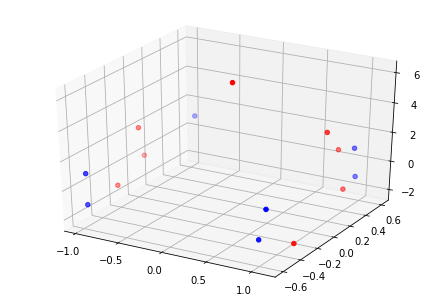

8
******************************
_________ORIG________
[[(0.08020590990781784, 0.9889488816261292, -0.877553403377533), (0.07963624596595764, -1.0108824968338013, -0.9592074751853943), (0.07738541811704636, 1.0155807733535767, 0.8429286479949951), (0.08484182506799698, -0.989445686340332, 0.937126100063324), (-0.0771368220448494, -1.050926685333252, -0.9078217148780823), (-0.07811067998409271, 1.0569827556610107, 0.8945885300636292), (-0.08050621300935745, -0.9984573721885681, 0.8911514282226562)]]
_________RECONST________
[[(0.08989927172660828, 0.478780597448349, -0.6136276125907898), (0.07458306103944778, 0.7287190556526184, 1.2929209470748901), (0.07315562665462494, 0.5025056600570679, 2.8235738277435303), (0.09086532890796661, -0.5554394721984863, -2.078014850616455), (-0.0778922587633133, -0.054439809173345566, 2.166773796081543), (-0.07617561519145966, -0.5109087228775024, -0.7390982508659363), (-0.07479339838027954, -0.02453266829252243, 0.3490419089794159), (0.0055310800671577

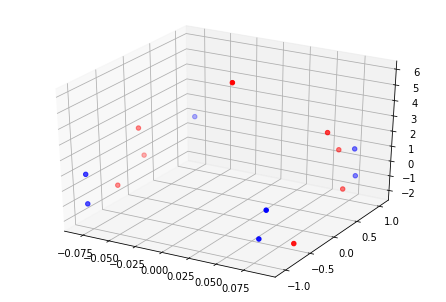

9
******************************
_________ORIG________
[[(0.9054247736930847, 0.2759987711906433, -0.16728754341602325), (0.898993968963623, -0.2821206748485565, -0.18285389244556427), (0.8735849857330322, 0.28343185782432556, 0.160687655210495), (0.9577585458755493, -0.27613744139671326, 0.1786438673734665), (-0.8707786202430725, -0.29329636693000793, -0.17305821180343628), (-0.8817722797393799, 0.29498645663261414, 0.1705355942249298), (-0.9088147878646851, -0.27865245938301086, 0.1698797196149826)]]
_________RECONST________
[[(0.7643067240715027, 0.11801999807357788, -0.37486815452575684), (0.9700677990913391, 0.21140286326408386, 0.8248758912086487), (0.933009922504425, 0.14695461094379425, 1.8113822937011719), (0.869535505771637, -0.16474568843841553, -1.4606688022613525), (-0.8586112260818481, -0.013927694410085678, 1.2656993865966797), (-0.9083478450775146, -0.145612433552742, -0.49008116126060486), (-0.9898197054862976, -0.015929318964481354, 0.26509028673171997), (-0.079363837

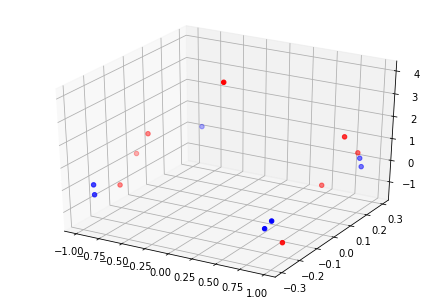

In [1506]:
for i in range(1,10):
    test_reconstruct(i,objs)

In [1460]:
for i in range(1,10):
    plot_obj(i,objs)

[ 0.73573095  0.73050535  0.70985854  0.77825636 -0.70757812 -0.71651137
 -0.73848557] [ 0.97905779 -1.00077283  1.00542402 -0.97954959 -1.04041648  1.04641187
 -0.98847109] [-0.76636577 -0.83767498  0.73612881  0.81839049 -0.79279983  0.78124338
  0.77824092]
[ 0.81008697  0.80433333  0.78159982  0.85691023 -0.77908891 -0.78892499
 -0.81312007] [ 0.97443181 -0.99604374  1.00067306 -0.97492135 -1.03550017  1.04146719
 -0.98380071] [-0.8263796  -0.90327239  0.79377425  0.88247836 -0.85488313  0.84242165
  0.8391847 ]
[ 0.14912954  0.14807035  0.14388531  0.15774927 -0.14342308 -0.14523381
 -0.1496879 ] [ 0.35608086 -0.36397704  0.36566877 -0.35625979 -0.37839541  0.38057593
 -0.35950449] [-0.48021263 -0.52489376  0.46126395  0.51281178 -0.49677452  0.48953313
  0.4876537 ]
[ 0.87354141  0.86733705  0.84282279  0.92403233 -0.84011525 -0.85072178
 -0.87681204] [ 0.65215385 -0.66661531  0.66971374 -0.65248156 -0.69302225  0.69701576
 -0.65842408] [-0.89811152 -0.98167574  0.86267304  0.959

In [1483]:
i=5
x_recovered, y_recovered, z_recovered = model.forward(torch.Tensor(train_xyz_obj[i].unsqueeze(0)).to(device), 
              torch.Tensor(train_xy_conn[i].unsqueeze(0)).to(device), extract_z=True)
z = z_recovered.cpu().detach().tolist()[0]
#y = y_recovered.cpu().detach().tolist()[0]
#x = x_recovered.cpu().detach().tolist()[0]

print(x,"\n\n",y,"\n\n",z)

# trace = go.Mesh3d(x=x,y=y,z=z,color='#0066FF',opacity=0.80)
# py.iplot([trace])

trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

tensor([[[ 0.9778,  0.9709,  0.9434,  1.0343, -0.9404, -0.9523, -0.9815,
           0.0000],
         [ 0.9533, -0.9745,  0.9790, -0.9538, -1.0131,  1.0189, -0.9625,
           0.0000],
         [-0.2029, -0.2218,  0.1949,  0.2167, -0.2099,  0.2069,  0.2061,
           0.0000]]]) 

 [ 0.6421333  -0.65637755  0.65942806 -0.64245582 -0.68237865  0.68631083
 -0.6483072 ] 

 [-0.2827427387237549, 0.7096775770187378, 1.5953646898269653, -1.3098256587982178, 1.0879499912261963, -0.4317934513092041, 0.272436261177063, 3.6846680641174316]


In [ ]:
 [-0.23599386 -0.2579518   0.22668184  0.25201425 -0.24413301  0.24057432
  0.23965067]
 [0.1274, 0.1235, 0.1364, -0.0264, -0.121, -0.393, 0.0617, 0.0404]

TEST BY RENDERING

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt


    
def test_reconstruct(N):
    print(N)
    print("******************************")
    fig = plt.figure()
    ax = Axes3D(fig)

    test_obj=test_xyz[N,:,:]
    d,t = test_obj.size()
    obj,conn = torch.Tensor.split(test_obj,[8,t-8],dim=1)
    #print(obj)
    #print(conn)
    fullobj = np.concatenate((obj,conn), axis=1)
    computed_z = model.forward(torch.Tensor([fullobj]).to(device), extract_z=True)
    orig_z = obj[2]


    print("_________ORIG________")

    x=obj[0]
    y=obj[1]
    z=obj[2]


    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()


    print("_________RECON________")

    fig = plt.figure()
    ax = Axes3D(fig)
    x=obj[0]
    y=obj[1]
    z=computed_z.to('cpu').detach().numpy()[0]
    #print("Test  obj's   z: ", obj[2])
    #print("Model computed z:", z)

    x=[(i-min(x))/(max(x)-min(x)) for i in x]
    y=[(i-min(y))/(max(y)-min(y)) for i in y]
    z=[(i-min(z))/(max(z)-min(z)) for i in z]

    verts = [list(zip(x, y,z))]
    #ax.add_collection3d(Poly3DCollection(verts))
    ax.scatter(x, y, z, c='r', marker='o')
    plt.show()



In [ ]:
N=[15,]

In [ ]:
for i in range(50,60):
    test_reconstruct(i)

In [ ]:
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgb(204, 204, 204)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

Test Performance

In [ ]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(test_xy[:,:,:], test_xyz[:,:,:])
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)
criterion = nn.L1Loss()
lr, epochs, batch_size = 1e-1 , 1 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
i = 0
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        local_xyz = local_xyz.to(device)
        output = model.forward(local_xy)
        output = output.to(device)
        #print("output:",output)
        #print("actual:", local_xyz[:,2,0:8])
        #loss = criterion(output, local_xyz[:,2,0:8])
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        
        #print(local_xy, local_xyz)
        #if (i%100 == 0): print("network loss -> ", loss)
        #model.zero_grad()
        #loss.backward()
        #optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(localaccum);                                           

In [ ]:
plt.ylabel('SDA')
plt.xlabel('Objects')
plt.ylim((0.06,0.08))
plt.plot(localaccum[0:1000])